# Natural Language Processing with Artificial Neural Networks

> “In God we trust. All others must bring data.” – W. Edwards Deming, statistician

# Word Embeddings

### What?
Convert words to vectors in a high dimensional space. Each dimension denotes an aspect like gender, type of object / word.

### Why?
By converting words to vectors we build relations between words. More similar the words in a dimension, more closer their scores are.

### Example
_W(green) = (1.2, 0.98, 0.05, ...)_

_W(red) = (1.1, 0.2, 0.5, ...)_

Here the vector values of _green_ and _red_ are very similar in one dimension because they both are colours. The value for second dimension is very different because red might be depicting something negative in the training data while green is used for positiveness.

By vectorizing we are indirectly building different kind of relations between words.

In [11]:
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
from keras.datasets import imdb

#### To Do: read blog data before this cell

# Reading blog post from data directory

In [1]:
import os
import pickle


In [2]:
DATA_DIRECTORY = os.path.join('../data')
print DATA_DIRECTORY

../data


In [3]:
male_posts = []
female_post = []

In [4]:
with open(os.path.join(DATA_DIRECTORY,"male_blog_list.txt"),"rb") as male_file:
    male_posts= pickle.load(male_file)
with open(os.path.join(DATA_DIRECTORY,"female_blog_list.txt"),"rb") as female_file:
    female_posts = pickle.load(female_file)

In [5]:
print len(female_posts)
print len(male_posts)

2252
2611


#### Remove stop words
```from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")```

In [6]:
filtered_male_posts = []
filtered_female_posts = []

for post_male in male_posts:
    if len(post_male) == 0:
        continue
    filtered_male_posts.append(post_male)

for post_female in female_posts:
    if len(post_female) == 0:
        continue
    filtered_female_posts.append(post_female)

In [7]:
print len(filtered_female_posts)
print len(filtered_male_posts)

2247
2595


In [8]:
filtered_female_posts = map(lambda x:unicode(x), filtered_female_posts)
filtered_male_posts = map(lambda x: unicode(x), filtered_male_posts)
posts = filtered_female_posts + filtered_male_posts    
type(posts[0])

unicode

In [9]:
print len(posts)
print type(posts[100])

4842
<type 'unicode'>


In [59]:
w2v = Word2Vec(sentences=map(lambda x: x.split(),posts[0:100]),iter=30,min_count=1)
#w2v.build_vocab(posts[0].split('.'))
#w2v.train(posts[0].split('.'))

In [ ]:
w2v.vocab.keys()

In [71]:
map(lambda x: x.split() , posts[0:1])

[[u'Well,',
  u'everyone',
  u'got',
  u'up',
  u'and',
  u'going',
  u'this',
  u'morning.',
  u"It's",
  u'still',
  u'raining,',
  u'but',
  u"that's",
  u'okay',
  u'with',
  u'me.',
  u'Sort',
  u'of',
  u'suits',
  u'my',
  u'mood.',
  u'I',
  u'could',
  u'easily',
  u'have',
  u'stayed',
  u'home',
  u'in',
  u'bed',
  u'with',
  u'my',
  u'book',
  u'and',
  u'the',
  u'cats.',
  u'This',
  u'has',
  u'been',
  u'a',
  u'lot',
  u'of',
  u'rain',
  u'though!',
  u'People',
  u'have',
  u'wet',
  u'basements,',
  u'there',
  u'are',
  u'lakes',
  u'where',
  u'there',
  u'should',
  u'be',
  u'golf',
  u'courses',
  u'and',
  u'fields,',
  u'everything',
  u'is',
  u'green,',
  u'green,',
  u'green.',
  u'But,',
  u'it',
  u'is',
  u'supposed',
  u'to',
  u'be',
  u'26',
  u'degrees',
  u'by',
  u'Friday,',
  u'so',
  u"we'll",
  u'be',
  u'dealing',
  u'with',
  u'mosquitos',
  u'next',
  u'week.',
  u'I',
  u'heard',
  u'Winnipeg',
  u'described',
  u'as',
  u'an',
  u'"Old',

In [13]:
posts[0]

u'Well, everyone got up and going this morning.  It\'s still raining, but that\'s okay with me.  Sort of suits my mood.  I could easily have stayed home in bed with my book and the cats.  This has been a lot of rain though!  People have wet basements, there are lakes where there should be golf courses and fields, everything is green, green, green.  But, it is supposed to be 26 degrees by Friday, so we\'ll be dealing with mosquitos next week.  I heard Winnipeg described as an "Old Testament" city on  urlLink CBC Radio One  last week and it sort of rings true.  Floods, infestations, etc., etc..'

In [75]:
w2v.similarity(u'Testament"', u'"Old')

0.88632810653679395

# We have the input data, building data model

In [14]:
import numpy as np

In [15]:
# 0 for male, 1 for female
concatenate_array = np.concatenate((np.zeros(len(filtered_male_posts)),np.ones(len(filtered_female_posts))))

In [16]:
len(concatenate_array)

4842

#### Create cross validation data

In [17]:
from sklearn.cross_validation import train_test_split
x_train,x_test,male_female_train,male_female_test = train_test_split(np.concatenate((filtered_male_posts,filtered_female_posts)),concatenate_array,test_size=0.2)

In [18]:
x_train.shape[0],male_female_train.shape[0],x_train

(3873,
 3873,
 array([ u"I watched Apocalypse Now a couple days ago. Man, what an amazing movie. I'm not really in the mood to write up a big post right now, so just go and watch it. Your jaw will drop at some of the visuals, too. I assure it.",
        u'The sun\u2019s graceful fingers Tease the Brisbane River playfully My sunken soul is ignited with a sparkle As the sky meets the earth with such dancing glee  Bright yellow sunflowers Adorn green fields and my backyard Such pretty things of nature God\u2019s creation to warm our cold hearts  A rainbow in the sky Reminds me of God\u2019s covenant to man Never again will a flood destroy all life On His faithfulness man can always depend  The puffy white clouds Overflow with God\u2019s glory As it rains His grace pours out Providing dry souls rest and recovery  All glory and praises to God For He has given me life and hope My King my Redeemer and my Lord  No more in darkness again I\u2019ll grope',
        u"We went on our trip and it wa

In [19]:
import gensim
LabeledSentence = gensim.models.doc2vec.LabeledSentence

In [20]:
def labelizeReviews(reviews,label_type):
    labelized = []
    for i,v in enumerate(reviews):
        if len(v) == 0:
            continue
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v,[label]))
    return labelized

In [21]:
x_train_label = labelizeReviews(x_train,'TRAIN')
x_test_label = labelizeReviews(x_test,'TEST')

print len(x_train_label),len(x_train)

3873 3873


### We have labelized reviews, now building Doc2Vec models using Distibuted Memory (DM) and Distributed Bag of Words (DBoW)

* **DM** - Given the context (set of paragraphs), predict the next word
* **DBoW** - Given the word, predict the context

In [22]:
import random

In [23]:
size = 300

In [24]:
#dm defines the training algorithm. By default (dm=1), distributed memory is used. Otherwise, dbow is employed.

#size is the dimensionality of the feature vectors.

#window is the maximum distance between the current and predicted word within a sentence.

#alpha is the initial learning rate (will linearly drop to zero as training progresses).

#seed = for the random number generator.

#min_count = ignore all words with total frequency lower than this.

#sample = threshold for configuring which higher-frequency words are randomly downsampled;
#default is 0 (off), useful value is 1e-5.
#workers = use this many worker threads to train the model (=faster training with multicore machines).

#hs = if 1 (default), hierarchical sampling will be used for model training (else set to 0).

#negative = if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20).

#dm_mean = if 0 (default), use the sum of the context word vectors. If 1, use the mean. Only applies when dm is used.

model_dm = gensim.models.Doc2Vec(min_count=1,window=10,size=size,sample=1e-3,negative=5,workers=20)
model_dbow = gensim.models.Doc2Vec(min_count=1,window=10,size=size,sample=1e-3,negative=5,workers=20,dm=0)

In [25]:
model_dm.build_vocab(np.concatenate((x_train_label,x_test_label)))
model_dbow.build_vocab(np.concatenate((x_train_label,x_test_label)))

In [27]:
x_train_label_np = np.array(x_train_label)

In [28]:
x_train_label_np.shape[0]

3873

In [29]:
for epoch in range(10):
    perm = np.random.permutation(x_train_label_np.shape[0])
    model_dm.train(x_train_label_np[perm])
    model_dbow.train(x_train_label_np[perm])

In [30]:
def getVecs(model,corpus,size):
    vecs = [np.array(model[z.labels[0]]).reshape((1,size)) for z in corpus]
    return np.concatenate(vecs)

In [31]:
train_vecs_dm = getVecs(model_dm,x_train_label_np,size)
train_vecs_dbow = getVecs(model_dbow,x_train_label_np,size)

In [32]:
train_vecs = np.hstack((train_vecs_dm,train_vecs_dbow))

In [33]:
train_vecs.shape

(3873, 600)

In [35]:
x_test_label_np = np.array(x_test_label)

In [36]:
for epoch in range(10):
    perm = np.random.permutation(x_test_label_np.shape[0])
    model_dm.train(x_test_label_np[perm])
    model_dbow.train(x_test_label_np[perm])

In [37]:
test_vecs_dm = getVecs(model_dm,x_test_label_np,size)
test_vecs_dbow = getVecs(model_dbow,x_test_label_np,size)

In [38]:
test_vecs = np.hstack((test_vecs_dm,test_vecs_dbow))
print test_vecs_dm.shape,test_vecs_dbow.shape,male_female_train.shape,male_female_test.shape

(969, 300) (969, 300) (3873,) (969,)


#### We have all the vectors now, we have to train the classifier

In [40]:
from sklearn.linear_model import SGDClassifier

#### SGD classifier with L1 regularization

In [41]:
lrl1 = SGDClassifier(loss='log',penalty='l1')

In [42]:
lrl1.fit(train_vecs,male_female_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [43]:
print 'Test Accuracy : %.2f' %lrl1.score(test_vecs,male_female_test)

Test Accuracy : 0.60


#### SGD classifier with L2 regularization

In [44]:
lrl2 = SGDClassifier(loss='log',penalty='l2')

In [45]:
lrl2.fit(train_vecs,male_female_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [46]:
print 'Test Accuracy : %.2f' %lrl2.score(test_vecs,male_female_test)

Test Accuracy : 0.56


# 5 fold cross validation

In [47]:
from sklearn.cross_validation import KFold
from sklearn import metrics
import pandas as pd

In [48]:
sgd_l1_kf = KFold(n=train_vecs.shape[0],n_folds=5,shuffle=True)

In [49]:
sgd_l1_kf

sklearn.cross_validation.KFold(n=3873, n_folds=5, shuffle=True, random_state=None)

In [50]:
trained_vecs_df = pd.DataFrame(train_vecs)
target_np = np.array(male_female_train)

In [51]:
trained_vecs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.027858,-0.070650,0.102599,-0.161764,-0.073124,0.138494,-0.156318,0.064498,0.059404,0.208494,...,-0.118318,0.017203,0.104568,0.054840,0.154994,-0.085229,-0.030719,-0.023108,0.164262,0.058002
1,0.068548,0.135392,0.050947,0.087081,0.091976,-0.073573,0.042152,0.331612,0.043737,-0.030143,...,-0.024347,0.133087,0.014530,0.234445,-0.080593,-0.188176,-0.002635,-0.181350,-0.181025,0.043562
2,0.076481,0.025331,0.082829,-0.096777,0.187631,0.062384,-0.079174,0.142538,0.048883,0.275707,...,-0.154620,0.071142,0.028617,0.088915,0.095054,-0.121361,-0.008483,-0.025283,0.110582,0.116103
3,0.057386,0.125311,0.119550,-0.150341,0.161147,0.078276,-0.043869,0.124369,0.108676,0.211083,...,0.075915,-0.061464,-0.073133,-0.237654,0.628716,-0.438802,0.003518,0.316205,0.289040,-0.253773
4,-0.022048,-0.012017,0.133229,-0.112235,0.130634,-0.007152,-0.100959,0.066252,0.047708,0.204717,...,-0.180021,0.164485,-0.035360,-0.136693,0.365096,-0.226461,-0.229254,0.060980,0.001445,-0.122389


In [52]:
trained_vecs_df.shape

(3873, 600)

In [53]:
sgd_l1_kf

sklearn.cross_validation.KFold(n=3873, n_folds=5, shuffle=True, random_state=None)

In [54]:
sgd_l1_metrics = []
for train_index, validate_index in sgd_l1_kf:
    sample_train,sample_validate = trained_vecs_df.loc[train_index],trained_vecs_df.loc[validate_index]
    
    sample_train_target,sample_validate_target = male_female_train[train_index],male_female_train[validate_index]
    
    #print sample_train.shape,sample_validate.shape,sample_train_target.shape,sample_validate_target.shape
    
    sgd_l1 = SGDClassifier(loss='log',penalty='l1')
    
    sgd_l1.fit(sample_train,sample_train_target)
    
    sgd_l1_predicted = sgd_l1.predict(sample_validate)
    
    sgd_l1_predicted_copy = sgd_l1_predicted.copy()
    
    sgd_l1_predicted[sgd_l1_predicted > 0.5] = 1
    sgd_l1_predicted[sgd_l1_predicted <= 0.5] = 0
  
    
    sgd_l1_analysis = pd.concat([pd.Series(sample_validate_target),pd.Series(sgd_l1_predicted)],axis=1)

    sgd_l1_analysis.columns = ['actual','prediction']
    
    sgd_l1_auc = metrics.roc_auc_score(sgd_l1_analysis.actual,sgd_l1_analysis.prediction)
        
    sgd_l1_metrics.append((sgd_l1_auc))
    

In [55]:
sgd_l1_metrics_df = pd.DataFrame(sgd_l1_metrics).mean()

In [57]:
import matplotlib
from matplotlib import pyplot

In [58]:
%matplotlib inline

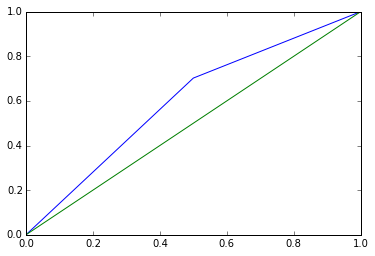

In [59]:
fpr, tpr, thresholds = metrics.roc_curve(sgd_l1_analysis.actual, sgd_l1_predicted_copy)
pyplot.plot(fpr, tpr)
pyplot.plot([0,1],[0,1])


# RNN using LSTM 
       




<img src="img/RNN-rolled.png"/ width="80px" height="80px">

<img src="img/RNN-unrolled.png"/ width="400px" height="400px">

<img src="img/LSTM3-chain.png"/ width="800px" height="800px">

_source: http://colah.github.io/posts/2015-08-Understanding-LSTMs_

In [60]:
from keras.optimizers import SGD
from keras.preprocessing.text import one_hot,text_to_word_sequence,base_filter
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.preprocessing import sequence

In [82]:
filtered_male_posts = []
filtered_female_posts = []

for post_male in male_posts:
    if len(post_male) == 0:
        continue
    filtered_male_posts.append(post_male)

for post_female in female_posts:
    if len(post_female) == 0:
        continue
    filtered_female_posts.append(post_female)

In [85]:
# text processing - one hot builds index of the words
male_one_hot = []
female_one_hot = []
n = 30000
for post in filtered_male_posts:
    try:
        male_one_hot.append(one_hot(post,n,split=" ",filters=base_filter(),lower=True))
    except Exception as e:
        continue

for post in filtered_female_posts:
    try:
        female_one_hot.append(one_hot(post,n,split=" ",filters=base_filter(),lower=True))
    except:
        continue

In [87]:
# 0 for male, 1 for female
concatenate_array_rnn = np.concatenate((np.zeros(len(male_one_hot)),np.ones(len(female_one_hot))))

In [88]:
x_train_rnn,x_test_rnn,y_train_rnn,y_test_rnn = train_test_split(np.concatenate((female_one_hot,male_one_hot)),concatenate_array_rnn,test_size=0.2)

In [89]:
maxlen = 100
x_train_rnn = sequence.pad_sequences(x_train_rnn,maxlen=maxlen)
x_test_rnn = sequence.pad_sequences(x_test_rnn,maxlen=maxlen)
print('x_train_rnn shape:', x_train_rnn.shape,y_train_rnn.shape)
print('x_test_rnn shape:', x_test_rnn.shape,y_test_rnn.shape)

('x_train_rnn shape:', (3706, 100), (3706,))
('x_test_rnn shape:', (927, 100), (927,))


In [90]:
max_features = 30000
dimension = 128
input_dimension = 128
output_dimension = 128
model = Sequential()
model.add(Embedding(max_features, dimension))
model.add(LSTM(input_dimension, output_dimension))
model.add(Dropout(0.5))
model.add(Dense(128, 1))
model.add(Activation('sigmoid'))

In [91]:
model.compile(loss='mean_squared_error',optimizer='sgd')

In [92]:
model.fit(x_train_rnn,y_train_rnn,batch_size=32,nb_epoch=4,validation_data=(x_test_rnn,y_test_rnn),show_accuracy=True)

Train on 3706 samples, validate on 927 samples
Epoch 0
3706/3706 [==============================] - 55s - loss: 0.2495 - acc: 1.0000 - val_loss: 0.2491 - val_acc: 1.0000
Epoch 1
3706/3706 [==============================] - 48s - loss: 0.2489 - acc: 1.0000 - val_loss: 0.2487 - val_acc: 1.0000
Epoch 2
3706/3706 [==============================] - 51s - loss: 0.2485 - acc: 1.0000 - val_loss: 0.2485 - val_acc: 1.0000
Epoch 3
3706/3706 [==============================] - 55s - loss: 0.2485 - acc: 1.0000 - val_loss: 0.2484 - val_acc: 1.0000


In [93]:
score,acc = model.evaluate(x_test_rnn,y_test_rnn,batch_size=32,show_accuracy=True)

927/927 [==============================] - 2s     


# Using TFIDF Vectorizer as an input instead of one hot

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
vectorizer = TfidfVectorizer(decode_error='ignore', norm='l2')
tfidf_male = vectorizer.fit_transform(clean_male_post_list)
tfidf_female = vectorizer.fit_transform(clean_female_post_list)

In [ ]:
flattened_array_tfidf_male = tfidf_male.toarray()
flattened_array_tfidf_female = tfidf_male.toarray()

In [ ]:
concatenate_array_rnn = np.concatenate((np.zeros(len(flattened_array_tfidf_male)),np.ones(len(flattened_array_tfidf_female))))

In [ ]:
x_train_rnn,x_test_rnn,y_train_rnn,y_test_rnn = train_test_split(np.concatenate((flattened_array_tfidf_male,flattened_array_tfidf_female)),concatenate_array_rnn,test_size=0.2)

In [ ]:
maxlen = 100
# x_train_rnn = sequence.pad_sequences(x_train_rnn,maxlen=maxlen)
# x_test_rnn = sequence.pad_sequences(x_test_rnn,maxlen=maxlen)
# print('x_train_rnn shape:', x_train_rnn.shape,y_train_rnn.shape)
# print('x_test_rnn shape:', x_test_rnn.shape,y_test_rnn.shape)

In [ ]:
max_features = 30000
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, 128))
model.add(Dropout(0.5))
model.add(Dense(128, 1))
model.add(Activation('sigmoid'))

In [ ]:
model.compile(loss='mean_squared_error',optimizer='sgd')

In [ ]:
model.fit(x_train_rnn,y_train_rnn,batch_size=32,nb_epoch=4,validation_data=(x_test_rnn,y_test_rnn),show_accuracy=True)

In [ ]:
score,acc = model.evaluate(x_test_rnn,y_test_rnn,batch_size=32,show_accuracy=True)

# Sentence Generation using RNN(LSTM)

In [95]:
# reading all the male text data into one string
male_post = ' '.join(filtered_male_posts[:2])

#building character set for the male posts
character_set_male = set(male_post)
#building two indices - character index and index of character
char_indices = dict((c, i) for i, c in enumerate(character_set_male))
indices_char = dict((i, c) for i, c in enumerate(character_set_male))


# cut the text in semi-redundant sequences of maxlen characters
maxlen = 20
step = 1
sentences = []
next_chars = []
for i in range(0, len(male_post) - maxlen, step):
    sentences.append(male_post[i : i + maxlen])
    next_chars.append(male_post[i + maxlen])


In [96]:
#Vectorisation of input
x_male = np.zeros((len(male_post),maxlen,len(character_set_male)),dtype=np.bool)
y_male = np.zeros((len(male_post),len(character_set_male)),dtype=np.bool)

print x_male.shape,y_male.shape

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x_male[i, t, char_indices[char]] = 1
    y_male[i, char_indices[next_chars[i]]] = 1

print x_male.shape,y_male.shape

(335, 20, 32) (335, 32)
(335, 20, 32) (335, 32)


In [97]:

#Building the model to generate text with 2 layers
auto_text_generating_male_model = Sequential()
auto_text_generating_male_model.add(LSTM(len(character_set_male),512,return_sequences=True))
auto_text_generating_male_model.add(Dropout(0.2))
auto_text_generating_male_model.add(LSTM(512,512,return_sequences=False))
auto_text_generating_male_model.add(Dropout(0.2))
auto_text_generating_male_model.add(Dense(512,len(character_set_male)))
auto_text_generating_male_model.add(Activation('sigmoid'))

In [98]:
auto_text_generating_male_model.compile(loss='mean_squared_error',optimizer='sgd')

In [99]:
import random,sys

In [ ]:
# helper function to sample an index from a probability array
def sample(a, diversity=0.75):
    if random.random() > diversity:
        return np.argmax(a)
    while 1:
        i = random.randint(0, len(a)-1)
        if a[i] > random.random():
            return i

In [ ]:
# train the model, output generated text after each iteration
for iteration in range(1,10):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    auto_text_generating_male_model.fit(x_male, y_male, batch_size=128, nb_epoch=1)

    start_index = random.randint(0, len(male_post) - maxlen - 1)

    for diversity in [0.2, 0.4, 0.6, 0.8]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = male_post[start_index : start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')

        for iteration in range(400):
            try:
                x = np.zeros((1, maxlen, len(character_set_male)))
                for t, char in enumerate(sentence):
                    x[0, t, char_indices[char]] = 1.

                preds = auto_text_generating_male_model.predict(x, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char

                #sys.stdout.write(next_char)
                #sys.stdout.flush()
            except:
                continue
                
        print sentence
        print()

()
--------------------------------------------------
('Iteration', 1)
Epoch 0
335/335 [==============================] - 11s - loss: 0.2502    
()
('----- diversity:', 0.2)
----- Generating with seed: " with since the star"
4ccgccccaoaaaaaplpk0
()
()
('----- diversity:', 0.4)
----- Generating with seed: " with since the star"
kkkkkwhptuffc0f,r000
()
()
('----- diversity:', 0.6)
----- Generating with seed: " with since the star"
dyyyy2Tyt4aeeifedIdd
()
()
('----- diversity:', 0.8)
----- Generating with seed: " with since the star"
0lfw.vnryoryyhg4o,ei
()
()
--------------------------------------------------
('Iteration', 2)
Epoch 0
335/335 [==============================] - 10s - loss: 0.2498    
()
('----- diversity:', 0.2)
----- Generating with seed: "et to hang out with "
yv yyyyvyym0mmeeewwf
()
()
('----- diversity:', 0.4)
----- Generating with seed: "et to hang out with "
,22I22T22v2222I222ln
()
()
('----- diversity:', 0.6)
----- Generating with seed: "et to hang out with "
eYrrga